In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import sys
import torch
import matplotlib.pyplot as plt
import umap
import os.path
sys.path.append('../')
import velovae as vv
from datetime import datetime

In [2]:
torch.cuda.is_available()

True

In [3]:
now = datetime.now()
date = now.strftime("%m_%d_%Y")

In [4]:
dataset = "10XMouse"
adata = sc.read_h5ad('../../RNA_ATAC/10x_mouse_brain/adata_postpro.h5ad')
adata_atac = sc.read_h5ad('../../RNA_ATAC/10x_mouse_brain/adata_atac_postpro.h5ad')

In [5]:
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

In [6]:
gene_plot = ["Robo2", "Satb2", 'Gria2', 'Grin2b', 'Eomes', 'Tle4']
np.all(np.isin(gene_plot, adata.var_names))

True

In [7]:
adata_atac.layers['Mc'] = adata_atac.layers['Mc'].A

In [8]:
adata, adata_atac

(AnnData object with n_obs × n_vars = 3365 × 936
     obs: 'n_counts', 'leiden'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
     uns: 'leiden_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 3365 × 936
     obs: 'n_counts'
     layers: 'Mc'
     obsp: 'connectivities')

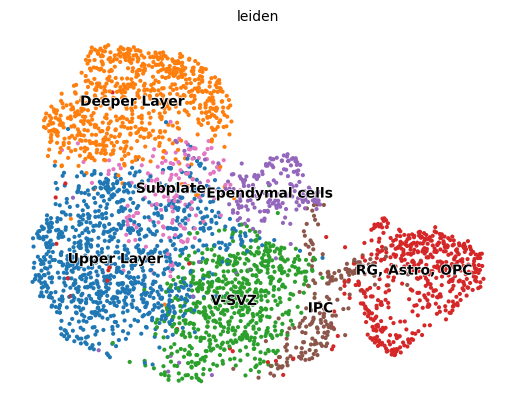

In [9]:
os.makedirs(figure_path_base, exist_ok=True)
scv.pl.scatter(adata, basis='umap', color='leiden')

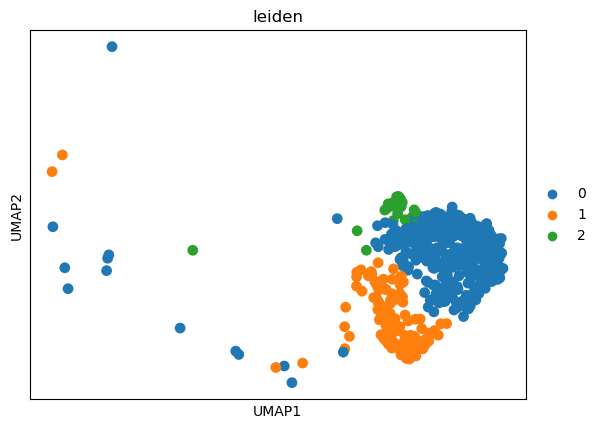

In [10]:
# Let's split RG, Astro, and OPC
adata_sub = adata[adata.obs['leiden'] == 'RG, Astro, OPC', :].copy()
sc.tl.leiden(adata_sub, resolution=0.3)
sc.pl.umap(adata_sub, color='leiden')

In [11]:
adata.obs['leiden'] = adata.obs['leiden'].astype('str')
adata.obs.loc[adata_sub[adata_sub.obs['leiden']=='0', :].obs_names, 'leiden'] = 'Astrocyte'
adata.obs.loc[adata_sub[adata_sub.obs['leiden']=='1', :].obs_names, 'leiden'] = 'Radial Glia'
adata.obs.loc[adata_sub[adata_sub.obs['leiden']=='2', :].obs_names, 'leiden'] = 'OPC'
adata.obs.loc[adata.obs['leiden']=='Ependymal cells', 'leiden'] = 'Ependymal'
adata.obs.loc[adata.obs['leiden']=='IPC', 'leiden'] = 'nIPC'

saving figure to file figures/10XMouse/umap.png


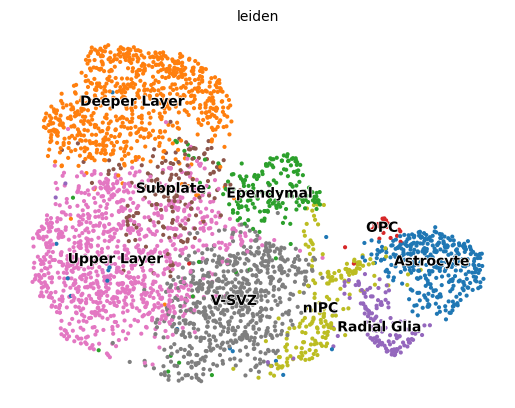

In [12]:
scv.pl.scatter(adata, basis='umap', color='leiden', save=figure_path_base+"/umap.png")

In [13]:
figure_path = figure_path_base+'/'+date
model_path = model_path_base+'/'+date
data_path = data_path_base

In [14]:
torch.manual_seed(2022)
np.random.seed(2022)
model = vv.VAEChrom(adata,
                    adata_atac,
                    device='cuda:0',
                    plot_init=False,
                    gene_plot=gene_plot,
                    cluster_key="leiden",
                    figure_path=figure_path,
                    embed="umap")

model.train(plot=False,
            gene_plot=gene_plot,
            figure_path=figure_path,
            embed="umap")

model.save_model(model_path)
model.save_anndata(data_path, file_name="out.h5ad")

Latent dimension set to 7.


Learning rate set to 5.8e-4 based on data sparsity.
Early stop threshold set to 0.5.
Using Gaussian Prior.
Initializing using the steady-state and dynamical models.


  0%|          | 0/936 [00:00<?, ?it/s]

862 out of 936 = 92.1% genes have good ellipse fits.
KS-test result: [1. 1. 1. 1. 1. 1. 1.]
Assigning cluster 6 to repressive.
Initial induction: 734, repression: 202 out of 936.
--------------------------- Train a VeloVAE ---------------------------
*********      Creating Training and Validation Datasets      *********
Total Number of Iterations Per Epoch: 10, test iteration: 18
*********                      Finished.                      *********
*********                      Stage  1                       *********
Epoch 1: Train ELBO = -3673.793, Test ELBO = -20168.468		Total Time =   0 h :  0 m :  0 s
Epoch 50: Train ELBO = 3012.307, Test ELBO = 3009.576		Total Time =   0 h :  0 m :  3 s
Epoch 100: Train ELBO = 3264.893, Test ELBO = 3246.065		Total Time =   0 h :  0 m :  6 s
Epoch 150: Train ELBO = 3358.157, Test ELBO = 3345.258		Total Time =   0 h :  0 m :  9 s
Epoch 200: Train ELBO = 3394.092, Test ELBO = 3378.623		Total Time =   0 h :  0 m : 12 s
Epoch 250: Train ELBO = 341

  0%|          | 0/3365 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.002
Average Set Size: 14
Finished. Actual Time:   0 h :  0 m :  2 s
*********             Velocity Refinement Round 1             *********
Epoch 1086: Train ELBO = 3391.065, Test ELBO = 3382.398		Total Time =   0 h :  1 m :  7 s
*********     Round 1: Early Stop Triggered at epoch 1086.     *********
*********     Retrieving best model from iteration 10847.      *********
Cell-wise KNN estimation.
Finished. Actual Time:   0 h :  0 m :  0 s
*********             Velocity Refinement Round 2             *********
Epoch 1110: Train ELBO = 3323.292, Test ELBO = 3332.454		Total Time =   0 h :  1 m :  9 s
*********     Round 2: Early Stop Triggered at epoch 1110.     *********
*********     Retrieving best model from iteration 11081.      *********
Change in x0: 0.183
Cell-wise KNN estimation.
Finished. Actual Time:   0 h :  0 m :  0 s
*********             Velocity Refinement Round 3             *********
Epoch 1135: Train ELBO = 3263.203, Test ELBO = 3274.866	

In [15]:
key = 'vae'
basis = "umap"

In [16]:
std_z = adata.obsm[f"{key}_std_z"]
z = adata.obsm[f"{key}_z"]

In [17]:
umap_obj = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.25, random_state=2022)
z_umap = umap_obj.fit_transform(z)

In [18]:
adata.obsm['X_z_umap'] = z_umap

computing velocity graph (using 1/8 cores)


  0%|          | 0/3365 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'vae_velocity_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_norm_umap', embedded velocity vectors (adata.obsm)


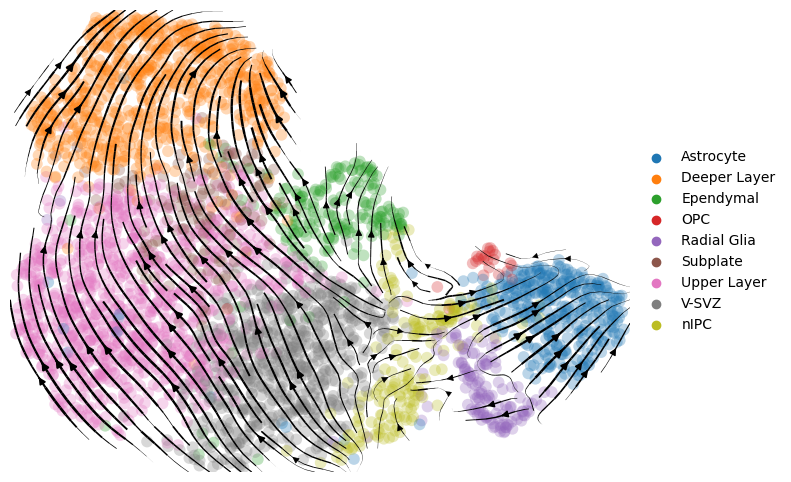

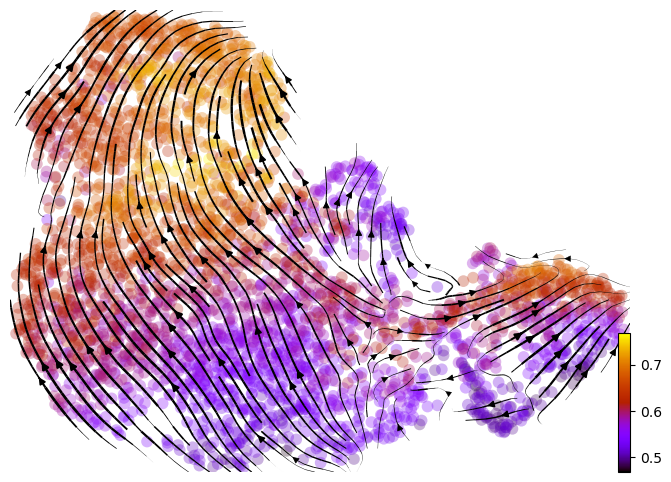

In [19]:
vv.model.velocity_graph(adata, key=key)
vv.velocity_embedding_stream(adata, key=key, basis='umap', color='leiden', title="", figsize=(8,6), legend_loc='right margin')
vv.velocity_embedding_stream(adata, key=key, basis='umap', color=f'{key}_time', color_map='gnuplot', title="", figsize=(8,6), legend_loc='right margin')

computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_norm_z_umap', embedded velocity vectors (adata.obsm)


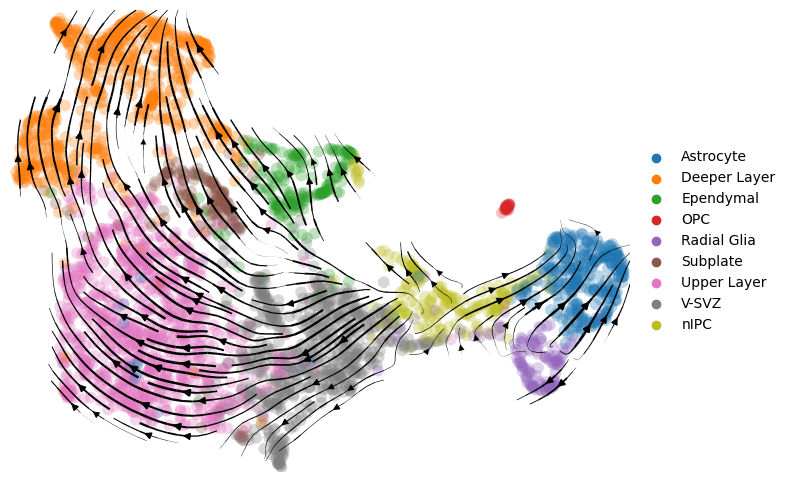

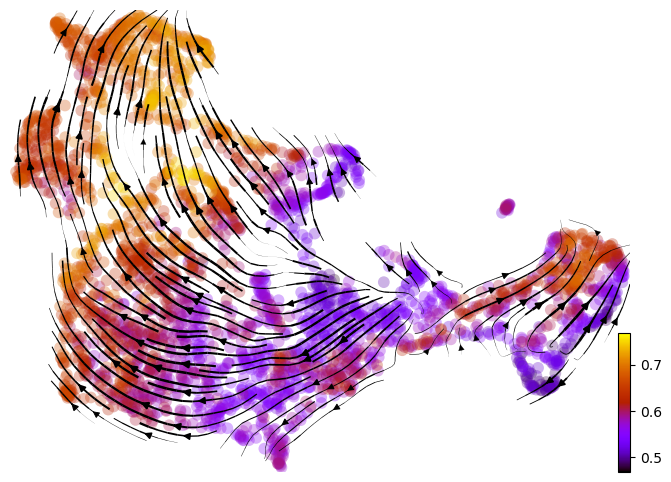

In [20]:
vv.velocity_embedding_stream(adata, key=key, basis='z_umap', color='leiden', title="", figsize=(8,6), legend_loc='right margin')
vv.velocity_embedding_stream(adata, key=key, basis='z_umap', color=f'{key}_time', color_map='gnuplot', title="", figsize=(8,6), legend_loc='right margin')

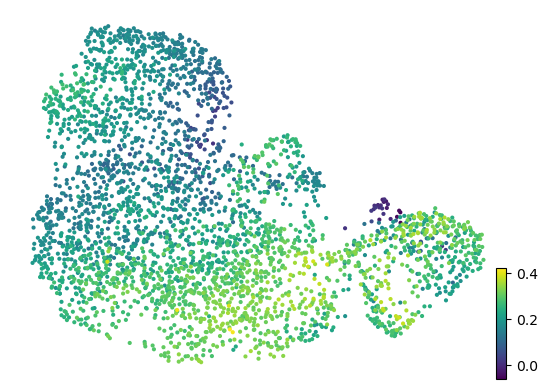

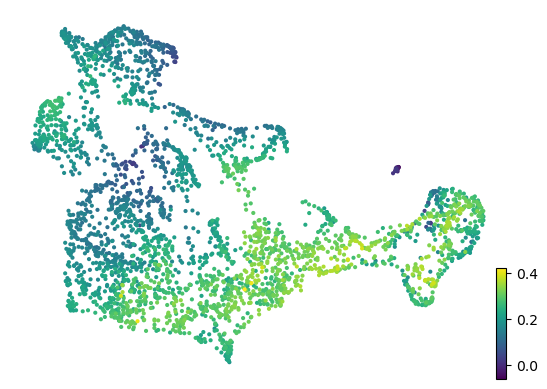

In [21]:
adata.layers['state_diff'] = adata.layers[f'{key}_kc'] - adata.layers[f'{key}_rho']
scv.pl.scatter(adata, basis='umap', color=np.mean(adata[:, adata.var[f'{key}_velocity_genes']].layers['state_diff'], axis=1), legend_loc='right margin')
scv.pl.scatter(adata, basis='z_umap', color=np.mean(adata[:, adata.var[f'{key}_velocity_genes']].layers['state_diff'], axis=1), legend_loc='right margin')

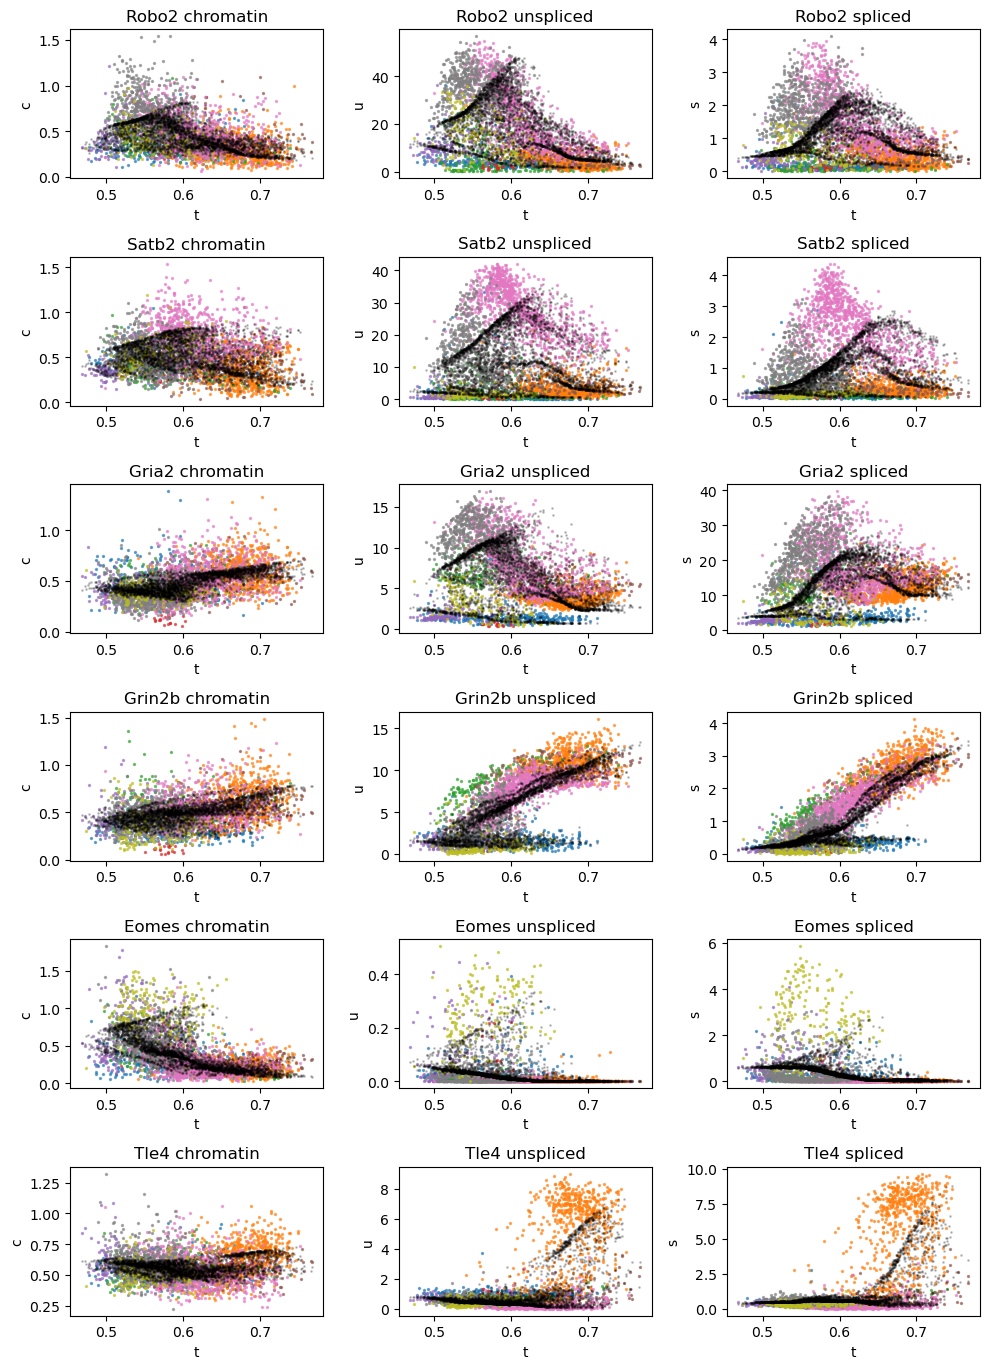

In [22]:
vv.dynamic_plot(adata, adata_atac, gene_plot, color_by='leiden')

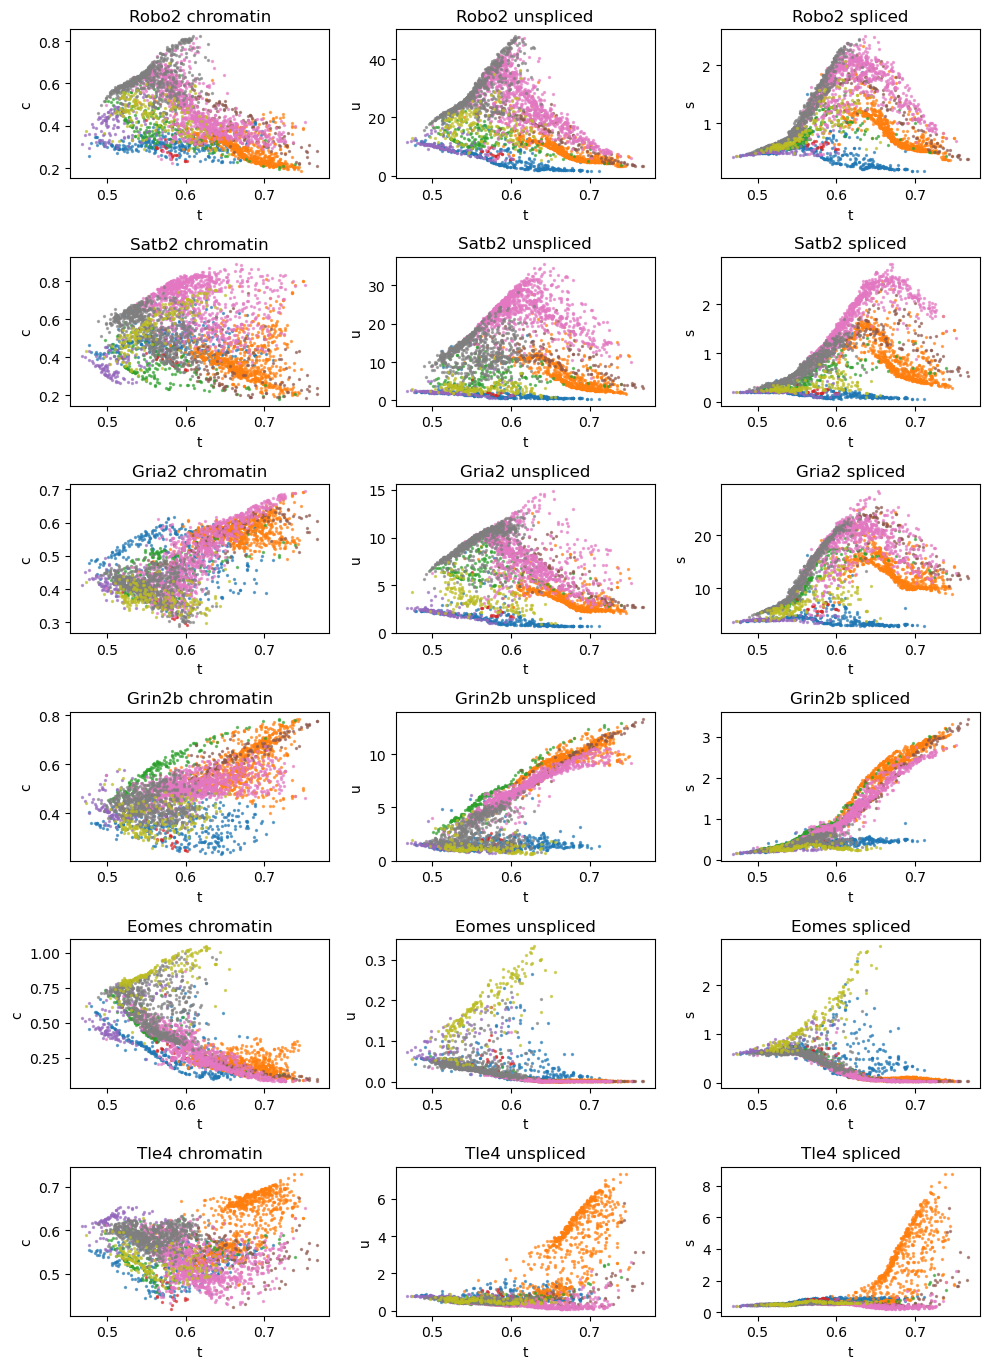

In [23]:
vv.dynamic_plot(adata, adata_atac, gene_plot, color_by='leiden', show_pred_only=True)

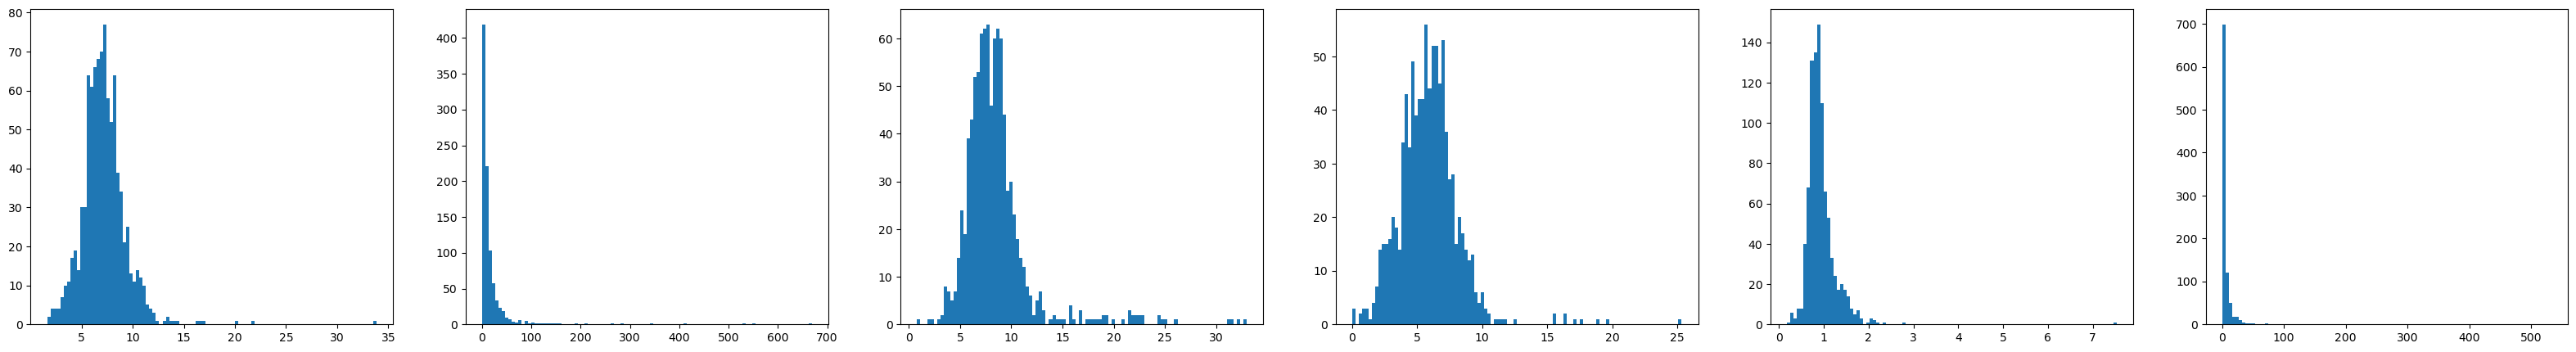

In [24]:
fig, axs = plt.subplots(1, 6, figsize=(40, 5))
axs[0].hist(adata.var[f'{key}_alpha_c'], bins=100);
axs[1].hist(adata.var[f'{key}_alpha'], bins=100);
axs[2].hist(adata.var[f'{key}_beta'], bins=100);
axs[3].hist(adata.var[f'{key}_gamma'], bins=100);
axs[4].hist(adata.var[f'{key}_scaling_c'], bins=100);
axs[5].hist(adata.var[f'{key}_scaling_u'], bins=100);

In [25]:
adata.write_h5ad(data_path_base+"/final.h5ad")